# This program applies graph based TextRank algorithm for extractive summarization

How to use:
 Under '1.3 : Sentence reprentation in TF-IDF' create the pick a story and put it in 'sentences_list' (sentences_list = input_texts[0]). And then run remaining part

### 1.0 : Configuration

In [1]:
## Set up working directory
import os
workdir = os.getcwd()
print("The working directory is :", workdir)

The working directory is : C:\Users\sattw\Documents\Github\NLP


In [105]:
## Read required libraries & utilities
import os, sys, string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump,load

import networkx as nx
from nltk.tokenize.punkt import PunktSentenceTokenizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

### 1.2 : Read Data 

In [3]:
NUM_SAMPLES      = 100 # number of samples from the original data.

In [4]:
##  function to read each document
def load_single_doc(filename):
    with open(filename, encoding = 'utf-8') as f:
        text = f.read()
        f.close()
    return text

##  function to extract news story and highlights
def extract_story(doc):
    idx = doc.find('@highlight')
    story_part, highlight_part = doc[:idx], doc[idx:].split('@highlight')
    highlight_part = [h.strip() for h in highlight_part if len(h)>0]
    return story_part, highlight_part

## function to load all stories from data directory
def load_all_stories(dir):
    stories = list()
    doc_iter = 0
    for files in os.listdir(dir):
        doc_iter += 1
        print("processing doc number {}".format(doc_iter))
        filename = os.path.join(dir, files)
        doc = load_single_doc(filename)
        story_part, highlight_part = extract_story(doc)
        if story_part is not None:
            stories.append({'story': story_part, 'highlight' : highlight_part})
            
        if doc_iter == NUM_SAMPLES:
            break
    return stories



In [5]:
# load stories
dir = os.path.join(workdir, 'Data', 'stories_text_summarization_dataset_train') 
stories = load_all_stories(dir)
print('Loaded Stories %d' % len(stories))

processing doc number 1
processing doc number 2
processing doc number 3
processing doc number 4
processing doc number 5
processing doc number 6
processing doc number 7
processing doc number 8
processing doc number 9
processing doc number 10
processing doc number 11
processing doc number 12
processing doc number 13
processing doc number 14
processing doc number 15
processing doc number 16
processing doc number 17
processing doc number 18
processing doc number 19
processing doc number 20
processing doc number 21
processing doc number 22
processing doc number 23
processing doc number 24
processing doc number 25
processing doc number 26
processing doc number 27
processing doc number 28
processing doc number 29
processing doc number 30
processing doc number 31
processing doc number 32
processing doc number 33
processing doc number 34
processing doc number 35
processing doc number 36
processing doc number 37
processing doc number 38
processing doc number 39
processing doc number 40
processin

In [6]:
## Clean data
## 1.4.1 : Remove CNN office if exists
## 1.4.2 : tokenize on whitespace
## 1.4.3 : convert to lowercase
## 1.4.4 : remove punctuation chars from each tokens
## 1.4.5 : remove words that have non-alphabatic chars

def data_cleansing(lines):
    cleaned = list()
    punct_table = str.maketrans('', '', string.punctuation)
    for line in lines:
        
        ## 1.4.1
        idx = line.find('(CNN) -- ')
        if idx > -1:
            line = line[idx+len('(CNN)'):]
            
        ## 1.4.2
        line = line.split()
        
        ## 1.4.3
        line = [word.lower() for word in line]
        
        ## 1.4.4
        line = [w.translate(punct_table) for w in line]
        
        ## 1.4.5
        line = [word for word in line if word.isalpha()]
        
        ## store as string
        cleaned.append(' '.join(line))
        
        ## remove empty strings
        cleaned = [c for c in cleaned if len(c) > 0]
    return cleaned

In [7]:
# clean stories
stories_cleaned = list()
for example in stories:
    cleaned_temp_s = str()
    cleaned_temp_h = str()
    
    example['story'] = data_cleansing(example['story'].split('\n'))
    example['highlight'] = data_cleansing(example['highlight'])
   
    ##cleaned_temp_s = ' '.join([str(n) for n in example['story']]) 
    ##cleaned_temp_h = ' '.join([str(n) for n in example['highlight']]) 
    
    ##stories_cleaned.append({'story': cleaned_temp_s , 'highlight' : cleaned_temp_h})
    stories_cleaned.append({'story': example['story'] , 'highlight' : example['highlight']})

In [8]:
stories[0]

{'story': ['its official us president barack obama wants lawmakers to weigh in on whether to use military force in syria',
  'obama sent a letter to the heads of the house and senate on saturday night hours after announcing that he believes military action against syrian targets is the right step to take over the alleged use of chemical weapons',
  'the proposed legislation from obama asks congress to approve the use of military force to deter disrupt prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction',
  'its a step that is set to turn an international crisis into a fierce domestic political battle',
  'there are key questions looming over the debate what did un weapons inspectors find in syria what happens if congress votes no and how will the syrian government react',
  'in a televised address from the white house rose garden earlier saturday the president said he would take his case to congress not because he has to but becaus

In [9]:
stories_cleaned[0]

{'story': ['its official us president barack obama wants lawmakers to weigh in on whether to use military force in syria',
  'obama sent a letter to the heads of the house and senate on saturday night hours after announcing that he believes military action against syrian targets is the right step to take over the alleged use of chemical weapons',
  'the proposed legislation from obama asks congress to approve the use of military force to deter disrupt prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction',
  'its a step that is set to turn an international crisis into a fierce domestic political battle',
  'there are key questions looming over the debate what did un weapons inspectors find in syria what happens if congress votes no and how will the syrian government react',
  'in a televised address from the white house rose garden earlier saturday the president said he would take his case to congress not because he has to but becaus

In [73]:
### Separate story and summary into different list 
input_texts         = []  # placeholder to save in input text (Story)
target_texts        = []  # placeholder to save in target text (Summary)

for i, val in enumerate(stories_cleaned):
    if i == NUM_SAMPLES:
        break
    input_texts.append(val["story"])
    target_texts.append(val["highlight"])

print(input_texts[0])
print(" ")
print(target_texts[0])



['its official us president barack obama wants lawmakers to weigh in on whether to use military force in syria', 'obama sent a letter to the heads of the house and senate on saturday night hours after announcing that he believes military action against syrian targets is the right step to take over the alleged use of chemical weapons', 'the proposed legislation from obama asks congress to approve the use of military force to deter disrupt prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction', 'its a step that is set to turn an international crisis into a fierce domestic political battle', 'there are key questions looming over the debate what did un weapons inspectors find in syria what happens if congress votes no and how will the syrian government react', 'in a televised address from the white house rose garden earlier saturday the president said he would take his case to congress not because he has to but because he wants to', 'whi

In [74]:
type(input_texts[0])

list

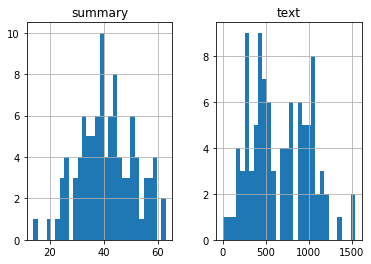

In [66]:
##Plot the sequence distribution of stories
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in input_texts:
      text_word_count.append(len(str(i).split()))

for i in target_texts:
      summary_word_count.append(len(str(i).split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [80]:
for i,v in enumerate(input_texts):
    print(len(str(v).split()))

1511
504
985
912
275
527
1212
811
522
439
289
402
786
515
1344
1079
751
259
1026
463
165
292
1188
496
1070
493
119
753
679
991
593
429
1176
220
473
188
437
454
1052
442
1114
1065
479
485
982
1058
754
876
361
84
283
911
540
223
267
312
535
1153
790
390
999
952
592
786
564
1077
438
936
883
262
264
1042
222
818
818
372
333
724
691
681
877
421
893
1539
702
937
586
343
204
432
401
414
1
174
1144
267
949
936
1050
1041


In [81]:
##Select top N samples with specific sequence length threshold (longests)
def sub_sample(seq_len_threshold):
    idx = [i for i,v in enumerate(input_texts) if len(str(v).split()) >= seq_len_threshold] ## used greater than, I want few long sentences 
    input_texts_subsample = [input_texts[i] for i in idx]
    target_texts_subsample = [target_texts[i] for i in idx]
    return input_texts_subsample,target_texts_subsample
    
input_texts,target_texts = sub_sample(seq_len_threshold=1200)

In [82]:
print(len(input_texts))
print(len(target_texts))

4
4


In [83]:
print(input_texts[0])
print("")
print(target_texts[0])

['its official us president barack obama wants lawmakers to weigh in on whether to use military force in syria', 'obama sent a letter to the heads of the house and senate on saturday night hours after announcing that he believes military action against syrian targets is the right step to take over the alleged use of chemical weapons', 'the proposed legislation from obama asks congress to approve the use of military force to deter disrupt prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction', 'its a step that is set to turn an international crisis into a fierce domestic political battle', 'there are key questions looming over the debate what did un weapons inspectors find in syria what happens if congress votes no and how will the syrian government react', 'in a televised address from the white house rose garden earlier saturday the president said he would take his case to congress not because he has to but because he wants to', 'whi

### 1.3 : Sentence reprentation in TF-IDF 

In [86]:
## Create sentence_list of oly one story (for further demo)
sentences_list = input_texts[0]

print(sentences_list)
type(sentences_list)


['its official us president barack obama wants lawmakers to weigh in on whether to use military force in syria', 'obama sent a letter to the heads of the house and senate on saturday night hours after announcing that he believes military action against syrian targets is the right step to take over the alleged use of chemical weapons', 'the proposed legislation from obama asks congress to approve the use of military force to deter disrupt prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction', 'its a step that is set to turn an international crisis into a fierce domestic political battle', 'there are key questions looming over the debate what did un weapons inspectors find in syria what happens if congress votes no and how will the syrian government react', 'in a televised address from the white house rose garden earlier saturday the president said he would take his case to congress not because he has to but because he wants to', 'whi

list

In [87]:
cv = CountVectorizer()
cv_matrix = cv.fit_transform(sentences_list)

In [92]:
print('The data type of bow matrix {}'.format(type(cv_matrix)))
print('Shape of the matrix {}'.format(cv_matrix.get_shape))
print('Size of the matrix is: {}'.format(sys.getsizeof(cv_matrix)))
print(cv.get_feature_names())
print(cv_matrix.toarray())

The data type of bow matrix <class 'scipy.sparse.csr.csr_matrix'>
Shape of the matrix <bound method spmatrix.get_shape of <67x582 sparse matrix of type '<class 'numpy.int64'>'
	with 1321 stored elements in Compressed Sparse Row format>>
Size of the matrix is: 56
['able', 'according', 'accountable', 'act', 'action', 'actions', 'address', 'administration', 'advisers', 'after', 'against', 'aggression', 'agreed', 'aim', 'alassad', 'alexei', 'alhalqi', 'all', 'alleged', 'allied', 'allies', 'alternative', 'ambassador', 'americanswere', 'amid', 'among', 'an', 'analyst', 'analyze', 'anchor', 'and', 'angeles', 'announcement', 'announcing', 'antiwar', 'any', 'appeared', 'applauded', 'approve', 'arabs', 'are', 'argued', 'armys', 'around', 'as', 'ascertain', 'asks', 'assad', 'assault', 'assertions', 'assets', 'at', 'attack', 'attacks', 'attempt', 'august', 'authority', 'authorization', 'backing', 'bad', 'ban', 'banner', 'barack', 'based', 'bashar', 'battle', 'be', 'because', 'become', 'been', 'bef

In [93]:
## Get TF-IDF
normal_matrix = TfidfTransformer().fit_transform(cv_matrix)
print(normal_matrix.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.31867527]
 [0.         0.         0.         ... 0.         0.         0.        ]]


### 1.4 :  Graph Reprentation

In [96]:
## Fraph represntation

res_graph = normal_matrix * normal_matrix.T

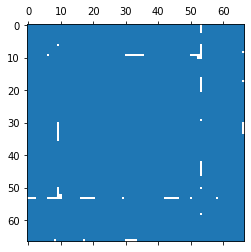

In [97]:
plt.spy(res_graph)

Number of edges 1613
Number of vertices 67


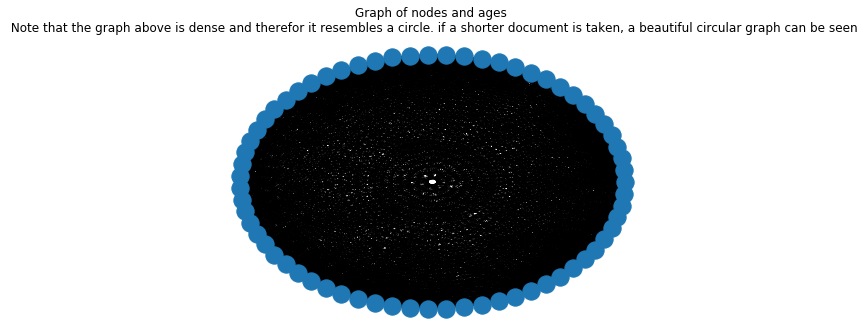

The memory used by the graph in Bytes is: 56


In [101]:
nx_graph = nx.from_scipy_sparse_matrix(res_graph)
nx.draw_circular(nx_graph)
print('Number of edges {}'.format(nx_graph.number_of_edges()))
print('Number of vertices {}'.format(nx_graph.number_of_nodes()))
plt.title("Graph of nodes and ages \n Note that the graph above is dense and therefor it resembles a circle. if a shorter document is taken, a beautiful circular graph can be seen")
# if a shorter document is taken, a beautiful circular graph can be seen")
plt.show()
print('The memory used by the graph in Bytes is: {}'.format(sys.getsizeof(nx_graph)))

### 1.5 Text Rank Algorithm 

In [102]:
## ranks is a dictionary with key=node(sentences) and value=textrank (the rank of each of the sentences)
ranks = nx.pagerank(nx_graph)

## analyse the data type of ranks
print(type(ranks))
print('The size used by the dictionary in Bytes is: {}'.format(sys.getsizeof(ranks)))

## print the dictionary
for i in ranks:
    print(i, ranks[i])

<class 'dict'>
The size used by the dictionary in Bytes is: 2280
0 0.019976847428981568
1 0.023361695390022325
2 0.018764779104440025
3 0.01100975056893165
4 0.01931024891746466
5 0.01889714354588037
6 0.01690639376191603
7 0.015458135235850223
8 0.00840505603295501
9 0.008231674251908747
10 0.01024490083558739
11 0.015472794489200832
12 0.019103545278298446
13 0.018650374594220455
14 0.01579626360760051
15 0.017845114230981337
16 0.01610366840875082
17 0.020741371529259714
18 0.015334012686168333
19 0.018788667663206235
20 0.014013086634892856
21 0.00971446925914435
22 0.01845198109150243
23 0.015265778398250532
24 0.017540521765514263
25 0.0170513554013666
26 0.016228312702071458
27 0.010916725372220316
28 0.010451779482670552
29 0.009674194912981727
30 0.014149954820830302
31 0.010469191014511567
32 0.01458748148266377
33 0.016280290230939087
34 0.009861936282525349
35 0.018366948714725606
36 0.014056658543079095
37 0.01227869438172878
38 0.012764440074220812
39 0.01041147620444355


### 1.6: FInding Impotrance Sentences 

In [106]:
sentence_array = sorted(((ranks[i], s) for i, s in enumerate(sentences_list)), reverse=True)
sentence_array = np.asarray(sentence_array)

In [107]:
## as sentence_array is in descending order wrt score value the first value is with the largest score 
## and the last vaue is with the smallest score
rank_max = float(sentence_array[0][0])
rank_min = float(sentence_array[len(sentence_array) - 1][0])
print(rank_max)
print(rank_min)

0.023361695390022325
0.008231674251908747


In [109]:
## Normalize the score
temp_array = []


flag = 0
if rank_max - rank_min == 0:
    temp_array.append(0)
    flag = 1

## If the sentence has different ranks
if flag != 1:
    for i in range(0, len(sentence_array)):
        temp_array.append((float(sentence_array[i][0]) - rank_min) / (rank_max - rank_min))

print(len(temp_array))

67


In [110]:
## We take the mean value of normalized scores
## any sentence with the normalized score 0.2 more than the mean value is considered to be imporartance.
## this approach can be twicked, if needed
threshold = (sum(temp_array) / len(temp_array)) + 0.2

In [111]:
important_sentence_list = []
if len(temp_array) > 1:
    for i in range(0, len(temp_array)):
        if temp_array[i] > threshold:
                important_sentence_list.append(sentence_array[i][1])
else:
    important_sentence_list.append(sentence_array[0][1])

### 1.7 : Get Summary 

In [115]:
def get_summary(topn):
    summary = " ".join(str(x) for i,x in enumerate(important_sentence_list) if i <= topn)
    return summary

summary = get_summary(5)


In [117]:

print ("Original story :", sentences_list)
print("")
print("Generated Summary :", summary)

Original story : ['its official us president barack obama wants lawmakers to weigh in on whether to use military force in syria', 'obama sent a letter to the heads of the house and senate on saturday night hours after announcing that he believes military action against syrian targets is the right step to take over the alleged use of chemical weapons', 'the proposed legislation from obama asks congress to approve the use of military force to deter disrupt prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction', 'its a step that is set to turn an international crisis into a fierce domestic political battle', 'there are key questions looming over the debate what did un weapons inspectors find in syria what happens if congress votes no and how will the syrian government react', 'in a televised address from the white house rose garden earlier saturday the president said he would take his case to congress not because he has to but because h